[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


(10392, 3)
posts        1
predicted    0
intensity    0
dtype: int64

Intensity distribution:
intensity
-2    1155
-1    4112
 0    4374
 1     750
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

          -2       0.58      0.79      0.67       231
          -1       0.76      0.67      0.71       823
           0       0.82      0.78      0.80       875
           1       0.42      0.59      0.49       150

    accuracy                           0.72      2079
   macro avg       0.65      0.71      0.67      2079
weighted avg       0.74      0.72      0.73      2079

Confusion Matrix:
[[183  33   5  10]
 [100 548 120  55]
 [ 13 122 682  58]
 [ 19  19  23  89]]


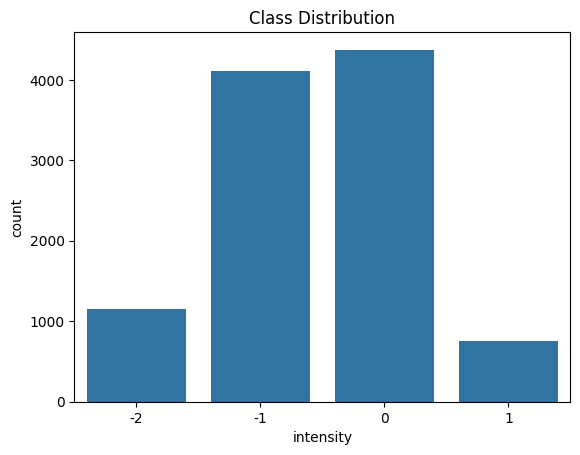

In [1]:
 # ===============================
# COMPLETE NLP PIPELINE (ONE CELL)
# ===============================

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# NLTK downloads
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset
df = pd.read_csv("/content/Mental Health Dataset.csv")

# -------------------------------
# Basic checks
# -------------------------------
print(df.shape)
print(df.isna().sum())

# Drop rows with missing posts
df = df.dropna(subset=['posts'])

# -------------------------------
# Text preprocessing
# -------------------------------
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['posts'].apply(clean_text)

# -------------------------------
# Label distribution
# -------------------------------
print("\nIntensity distribution:")
print(df['intensity'].value_counts().sort_index())

# -------------------------------
# Train-test split
# -------------------------------
X = df['clean_text']
y = df['intensity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# -------------------------------
# TF-IDF Vectorization
# -------------------------------
tfidf = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1,2),
    min_df=5,
    stop_words='english'
)

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# -------------------------------
# Model training (balanced)
# -------------------------------
model = LogisticRegression(
    max_iter=2000,
    class_weight='balanced'
)

model.fit(X_train_vec, y_train)

# -------------------------------
# Evaluation
# -------------------------------
y_pred = model.predict(X_test_vec)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# -------------------------------
# Optional visualization
# -------------------------------
sns.countplot(x='intensity', data=df)
plt.title("Class Distribution")
plt.show()


In [2]:
from sklearn.svm import LinearSVC

svm = LinearSVC(class_weight='balanced')
svm.fit(X_train_vec, y_train)
print(classification_report(y_test, svm.predict(X_test_vec)))


              precision    recall  f1-score   support

          -2       0.63      0.69      0.66       231
          -1       0.73      0.71      0.72       823
           0       0.78      0.80      0.79       875
           1       0.52      0.44      0.47       150

    accuracy                           0.72      2079
   macro avg       0.66      0.66      0.66      2079
weighted avg       0.72      0.72      0.72      2079



Final Tuning

In [3]:
model = LogisticRegression(
    max_iter=3000,
    class_weight={-2:1.2, -1:1.0, 0:1.0, 1:3.0}
)

model.fit(X_train_vec, y_train)
print(classification_report(y_test, model.predict(X_test_vec)))


              precision    recall  f1-score   support

          -2       0.72      0.63      0.67       231
          -1       0.72      0.75      0.74       823
           0       0.80      0.80      0.80       875
           1       0.54      0.51      0.52       150

    accuracy                           0.74      2079
   macro avg       0.70      0.67      0.68      2079
weighted avg       0.74      0.74      0.74      2079



Error Analysis

In [4]:
y_pred = model.predict(X_test_vec)
errors = df.loc[X_test.index][y_test != y_pred]

errors[['posts', 'intensity']].sample(5)


,posts,intensity
7632,hi all ia ve post before my mom was diagnose w...,0
7780,my father have a ct scan last month and have a...,0
5903,my mom have move to stage 4 lung cancer back i...,0
2579,one year ago my wife r was active energetic an...,0
526,here is an email I receive from go2god I think...,0


In [5]:
import joblib

# Save TF-IDF vectorizer
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

# Save trained Logistic Regression model
joblib.dump(model, 'logreg_model.pkl')

# Save SVM model (if you want)
joblib.dump(svm, 'svm_model.pkl')


['svm_model.pkl']

In [6]:
# Example: new/unseen posts
new_posts = [
    "I feel very anxious and stressed lately.",
    "Life is going well, I am happy with everything!"
]

# Clean the text
new_posts_clean = [clean_text(post) for post in new_posts]


In [7]:
# Convert to TF-IDF vectors
new_posts_vec = tfidf.transform(new_posts_clean)


In [8]:
# Logistic Regression predictions
predictions = model.predict(new_posts_vec)

# Show results
for post, pred in zip(new_posts, predictions):
    print(f"Post: {post}\nPredicted intensity: {pred}\n")


Post: I feel very anxious and stressed lately.
Predicted intensity: 0

Post: Life is going well, I am happy with everything!
Predicted intensity: 1



In [9]:
probabilities = model.predict_proba(new_posts_vec)
print(probabilities)


[[0.05830598 0.42689964 0.43629707 0.07849731]
 [0.09864486 0.13751504 0.33403784 0.42980226]]


In [10]:
threshold = 0.6  # example threshold
low_confidence = [i for i, probs in enumerate(probabilities) if max(probs) < threshold]

for idx in low_confidence:
    print("Low confidence prediction:", new_posts[idx])


Low confidence prediction: I feel very anxious and stressed lately.
Low confidence prediction: Life is going well, I am happy with everything!


In [11]:
# ===============================
# PREDICTION FUNCTION
# ===============================

def predict_intensity(posts, model, vectorizer, threshold=0.6):
    """
    Predicts intensity for a list of posts with low-confidence detection.

    Args:
        posts (list of str): New/unseen text posts
        model: Trained sklearn model (must support predict; optional: predict_proba)
        vectorizer: Trained TF-IDF vectorizer
        threshold (float): Confidence threshold for low-confidence flag

    Returns:
        list of dict: Each dict contains post, predicted_intensity, confidence, low_confidence
    """
    # Step 1: Clean posts
    posts_clean = [clean_text(p) for p in posts]

    # Step 2: Convert to TF-IDF vectors
    X_vec = vectorizer.transform(posts_clean)

    # Step 3: Predict intensity
    preds = model.predict(X_vec)

    # Step 4: Calculate confidence (if model supports predict_proba)
    results = []
    try:
        probs = model.predict_proba(X_vec)
        for post, pred, prob in zip(posts, preds, probs):
            confidence = max(prob)
            low_conf = confidence < threshold
            results.append({
                'post': post,
                'predicted_intensity': pred,
                'confidence': confidence,
                'low_confidence': low_conf
            })
    except AttributeError:
        # For models like LinearSVC without predict_proba
        for post, pred in zip(posts, preds):
            results.append({
                'post': post,
                'predicted_intensity': pred,
                'confidence': None,
                'low_confidence': None
            })

    return results

# ===============================
# Example usage with unseen posts
# ===============================
new_posts = [
    "I feel extremely anxious and stressed lately.",
    "Life is beautiful, I am happy today!",
    "I am feeling very low and hopeless..."
]

results = predict_intensity(new_posts, model, tfidf, threshold=0.6)

# Display results
for r in results:
    print(f"Post: {r['post']}")
    print(f"Predicted Intensity: {r['predicted_intensity']}")
    print(f"Confidence: {r['confidence']}")
    print(f"Low Confidence: {r['low_confidence']}")
    print("-"*50)

# ===============================
# Optional: Save this pipeline for deployment
# ===============================
joblib.dump({
    'vectorizer': tfidf,
    'model': model,
    'preprocessing_function': clean_text
}, 'nlp_pipeline.pkl')


Post: I feel extremely anxious and stressed lately.
Predicted Intensity: -1
Confidence: 0.5954320278248079
Low Confidence: True
--------------------------------------------------
Post: Life is beautiful, I am happy today!
Predicted Intensity: 1
Confidence: 0.8778694254228675
Low Confidence: False
--------------------------------------------------
Post: I am feeling very low and hopeless...
Predicted Intensity: 0
Confidence: 0.7655035728412288
Low Confidence: False
--------------------------------------------------


['nlp_pipeline.pkl']

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


===== Logistic Regression (BERT) =====
              precision    recall  f1-score   support

          -2       0.61      0.84      0.71       231
          -1       0.76      0.64      0.70       823
           0       0.84      0.75      0.79       875
           1       0.34      0.65      0.45       150

    accuracy                           0.71      2079
   macro avg       0.64      0.72      0.66      2079
weighted avg       0.75      0.71      0.72      2079



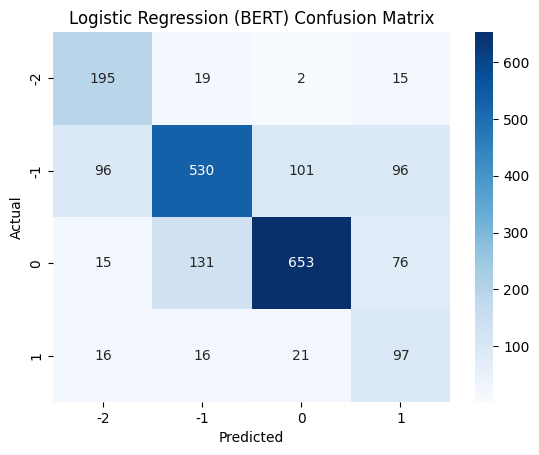


===== Random Forest (BERT) =====
              precision    recall  f1-score   support

          -2       0.74      0.47      0.57       231
          -1       0.63      0.79      0.70       823
           0       0.78      0.79      0.79       875
           1       0.84      0.11      0.19       150

    accuracy                           0.70      2079
   macro avg       0.75      0.54      0.56      2079
weighted avg       0.72      0.70      0.69      2079



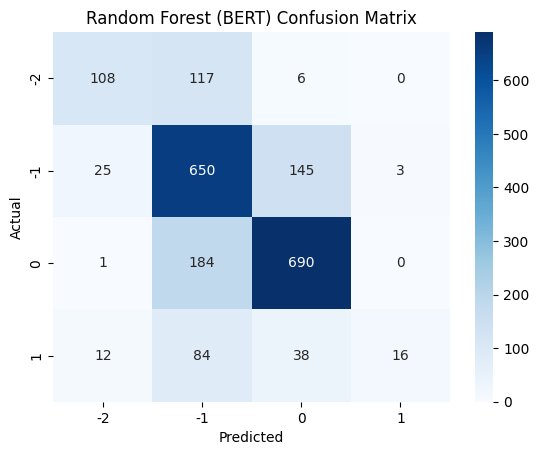


===== XGBoost (BERT) =====
              precision    recall  f1-score   support

          -2       0.00      0.00      0.00         0
          -1       0.00      0.00      0.00         0
           0       0.01      0.03      0.01       231
           1       0.13      0.01      0.02       823
           2       0.00      0.00      0.00       875
           3       0.00      0.00      0.00       150

    accuracy                           0.01      2079
   macro avg       0.02      0.01      0.01      2079
weighted avg       0.05      0.01      0.01      2079



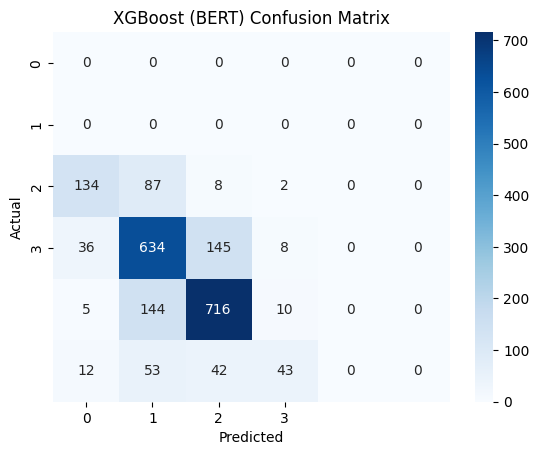

Post: I feel extremely anxious and stressed lately.
Predicted Intensity: -1
Confidence: 0.8644902833236001
Low Confidence: False
--------------------------------------------------
Post: Life is beautiful, I am happy today!
Predicted Intensity: 1
Confidence: 0.9700048081958893
Low Confidence: False
--------------------------------------------------
Post: I am feeling very low and hopeless...
Predicted Intensity: -2
Confidence: 0.9309954993850411
Low Confidence: False
--------------------------------------------------
Post: I know as parent of child with down syndrome that you have all hear that our child are at a high risk of leukemia as parent we read up on it and then say well that will not happen to my child well when will have just turn 2yr old he start bruise the thought of leukemia breafly cross my mind but I quickly push it out of my mind and rationalize it by say that he was a rough playing 2yr old and it was normal to bruise now and then I have just go to work a few month befor

['nlp_pipeline_bert.pkl']

In [12]:
# ===============================
# BERT EMBEDDINGS PIPELINE
# ===============================

# Install and imports
!pip install -q sentence-transformers
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib

# -------------------------------
# Ensure class_weight_dict exists
# -------------------------------
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, weights))

# -------------------------------
# Load BERT model
# -------------------------------
bert_model = SentenceTransformer('all-MiniLM-L6-v2')  # lightweight, fast

# -------------------------------
# Convert posts to BERT embeddings
# -------------------------------
X_train_bert = bert_model.encode(X_train.tolist(), convert_to_tensor=False, batch_size=32)
X_test_bert = bert_model.encode(X_test.tolist(), convert_to_tensor=False, batch_size=32)

# -------------------------------
# Train Models on BERT embeddings
# -------------------------------
# Logistic Regression
logreg_bert = LogisticRegression(max_iter=3000, class_weight=class_weight_dict, random_state=42)
logreg_bert.fit(X_train_bert, y_train)

# Random Forest
rf_bert = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42)
rf_bert.fit(X_train_bert, y_train)

# XGBoost
# XGBoost requires labels starting from 0 if there are negative numbers
label_mapping = {k: i for i, k in enumerate(sorted(np.unique(y_train)))}
y_train_xgb = y_train.map(label_mapping)
y_test_xgb = y_test.map(label_mapping)

xgb_bert = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42)
xgb_bert.fit(X_train_bert, y_train_xgb)

# -------------------------------
# Evaluation function
# -------------------------------
def evaluate_model_bert(model, X_test, y_test, model_name="Model", label_map=None):
    """
    Evaluate a model on test data with confusion matrix.
    If label_map is provided, remaps predicted labels to original.
    """
    y_pred = model.predict(X_test)

    if label_map is not None:
        # remap back to original labels
        inv_map = {v:k for k,v in label_map.items()}
        y_pred = np.array([inv_map[p] for p in y_pred])

    print(f"\n===== {model_name} =====")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

# Evaluate all models
evaluate_model_bert(logreg_bert, X_test_bert, y_test, "Logistic Regression (BERT)")
evaluate_model_bert(rf_bert, X_test_bert, y_test, "Random Forest (BERT)")
evaluate_model_bert(xgb_bert, X_test_bert, y_test_xgb, "XGBoost (BERT)", label_map=label_mapping)

# -------------------------------
# Prediction function for unseen posts (BERT)
# -------------------------------
def predict_intensity_bert(posts, model, bert_model, threshold=0.6):
    """
    Predict intensity for new posts using BERT embeddings with low-confidence detection.
    """
    # Clean posts
    posts_clean = [clean_text(p) for p in posts]

    # Convert to BERT embeddings
    X_vec = bert_model.encode(posts_clean, convert_to_tensor=False, batch_size=32)

    # Predict intensity
    preds = model.predict(X_vec)

    # Confidence calculation (if model supports predict_proba)
    results = []
    try:
        probs = model.predict_proba(X_vec)
        for post, pred, prob in zip(posts, preds, probs):
            confidence = max(prob)
            low_conf = confidence < threshold
            results.append({
                'post': post,
                'predicted_intensity': pred,
                'confidence': confidence,
                'low_confidence': low_conf
            })
    except AttributeError:
        for post, pred in zip(posts, preds):
            results.append({
                'post': post,
                'predicted_intensity': pred,
                'confidence': None,
                'low_confidence': None
            })

    return results

# -------------------------------
# Example usage
# -------------------------------
new_posts = [
    "I feel extremely anxious and stressed lately.",
    "Life is beautiful, I am happy today!",
    "I am feeling very low and hopeless...",
    "I know as parent of child with down syndrome that you have all hear that our child are at a high risk of leukemia as parent we read up on it and then say well that will not happen to my child well when will have just turn 2yr old he start bruise the thought of leukemia breafly cross my mind but I quickly push it out of my mind and rationalize it by say that he was a rough playing 2yr old and it was normal to bruise now and then I have just go to work a few month before and will have get a little more fussy and whinny but that is normal to right well then he get sick and like a lot of child with down when he get sick he get sick so we take he to the doc on a friday they say he have a cold and I tell my boss that he was sick and not to be surpise if I call and say he was in the hospital because they offten have to do that when he get sick she say ok and when sit get there sure enough he was much sicker and we take he to the er they tell we he have rsv and send we home with some med by the time we get home he was much bad and we take he back this time they order more test and put he in the hospital then my world start come down around I first they say that some of his blood work come back bad that they want to retest but it was probley nothing then that come back and they say they want to move he to icu just to keep a well I on he I start get scared that thought come back leukemia put again I try to push it out of my mind because no one want to think the bad well it was not long at all before the doc come in and say we believe william have leukemia they quickly fly he from beaumont tx to houston tx texas childrens hospital will is do really well now he is in remision but still have 3 1 2 yrs of chemo he was up run around but now can not walk anymore due to one of the chemos vinchristin but it will come back and he have just find other way to get around nothing is go to slow he dow I write all of this to say please do not dwell on it but if you see any symptom of leukemia in your child please get it check out it is well to find out because you are look for it than to find out like I and most other parent I have talk to by accident"
]

results_bert = predict_intensity_bert(new_posts, logreg_bert, bert_model, threshold=0.6)

for r in results_bert:
    print(f"Post: {r['post']}")
    print(f"Predicted Intensity: {r['predicted_intensity']}")
    print(f"Confidence: {r['confidence']}")
    print(f"Low Confidence: {r['low_confidence']}")
    print("-"*50)

# -------------------------------
# Save BERT pipeline for deployment
# -------------------------------
joblib.dump({
    'bert_model': bert_model,
    'model': logreg_bert,
    'preprocessing_function': clean_text
}, 'nlp_pipeline_bert.pkl')


In [13]:
new_posts = ["the third know human retrovirus xmrv seem to be emerge as a player in many illness a link have already been make to a certain type of prostate cancer in a recent study dr ila singh document that xmrv have a strong link to human cancer and may be associate with cervical cancer lymphomas leukemia and breast cancer and of course the wpi have make the link to I cfs on tuesday december 14 the fda blood product advisory committee will be hold a meeting to discuss the potential danger of murine leukemia virus mlvs in the blood supply the public is invite to participate http cfsuntie com blog2 2010 12 01 retrovirus victim uniteit in the blood al"]
results_bert = predict_intensity_bert(new_posts, logreg_bert, bert_model, threshold=0.6)

for r in results_bert:
    print(f"Post: {r['post']}")
    print(f"Predicted Intensity: {r['predicted_intensity']}")
    print(f"Confidence: {r['confidence']}")
    print(f"Low Confidence: {r['low_confidence']}")
    print("-"*50)

Post: the third know human retrovirus xmrv seem to be emerge as a player in many illness a link have already been make to a certain type of prostate cancer in a recent study dr ila singh document that xmrv have a strong link to human cancer and may be associate with cervical cancer lymphomas leukemia and breast cancer and of course the wpi have make the link to I cfs on tuesday december 14 the fda blood product advisory committee will be hold a meeting to discuss the potential danger of murine leukemia virus mlvs in the blood supply the public is invite to participate http cfsuntie com blog2 2010 12 01 retrovirus victim uniteit in the blood al
Predicted Intensity: 0
Confidence: 0.9346118816382127
Low Confidence: False
--------------------------------------------------


In [14]:
new_posts = ["I am only 23 and lose my mom to cancer 5 month ago how on earth do I deal with the awful flashback of she being sick when I get they I freak out because she was in incredible pain for a year and a half the vision invade my dream and give I nightmare I am also absolutely terrified that I will get cancer even though the cancer she have is not hereditary my sister die at the age of 2 of leukemia as well the doctor say there was probably not a link but I am extremely paranoid all the time I am incredibly healthy for my age but sometimes thing just happen regardless of the preparation you make my mom was my world and my good friend I was not as close with my father but am close to he now I feel like there is a huge piece of I miss and a void that need fill is it possible that the love of a significant other could come close to fill the void I have never been in a relationship or in love so I am not sure I know I have close family and friend that are helpful but I am incredibly lonely and I can not seem to shake it please leave comment"]
results_bert = predict_intensity_bert(new_posts, logreg_bert, bert_model, threshold=0.6)

for r in results_bert:
    print(f"Post: {r['post']}")
    print(f"Predicted Intensity: {r['predicted_intensity']}")
    print(f"Confidence: {r['confidence']}")
    print(f"Low Confidence: {r['low_confidence']}")
    print("-"*50)

Post: I am only 23 and lose my mom to cancer 5 month ago how on earth do I deal with the awful flashback of she being sick when I get they I freak out because she was in incredible pain for a year and a half the vision invade my dream and give I nightmare I am also absolutely terrified that I will get cancer even though the cancer she have is not hereditary my sister die at the age of 2 of leukemia as well the doctor say there was probably not a link but I am extremely paranoid all the time I am incredibly healthy for my age but sometimes thing just happen regardless of the preparation you make my mom was my world and my good friend I was not as close with my father but am close to he now I feel like there is a huge piece of I miss and a void that need fill is it possible that the love of a significant other could come close to fill the void I have never been in a relationship or in love so I am not sure I know I have close family and friend that are helpful but I am incredibly lonely 

In [15]:
def predict_intensity_auto(
    posts,
    tfidf_model,
    tfidf_vectorizer,
    bert_model,
    bert_logreg_model,
    threshold=0.6
):
    # ---------- TF-IDF ----------
    tfidf_results = predict_intensity(
        posts,
        model=tfidf_model,
        vectorizer=tfidf_vectorizer,
        threshold=threshold
    )

    # ---------- BERT ----------
    bert_results = predict_intensity_bert(
        posts,
        model=bert_logreg_model,
        bert_model=bert_model,
        threshold=threshold
    )

    combined_results = []

    for tfidf_res, bert_res in zip(tfidf_results, bert_results):
        # If both have confidence → choose higher
        if tfidf_res['confidence'] is not None and bert_res['confidence'] is not None:
            chosen = tfidf_res if tfidf_res['confidence'] >= bert_res['confidence'] else bert_res
        elif tfidf_res['confidence'] is not None:
            chosen = tfidf_res
        else:
            chosen = bert_res

        combined_results.append(chosen)

    return combined_results


In [16]:
new_posts = [
    "its been 2 year and like many it was the first very personal relationship I have with a girl to this day I always say that she pass away from cancer leukemia to be exact yes she have leukemia apparently she s do much well now but our relationship was difficult I do not know about how a womans mind work but I know its very complex and can be influence by her close friend and family ever since than all the happy thought new beginning and even new emotion have all disappear I think that this was something very special an answer to many thing she was teach I in a way she was show I compassion and kindness which lead I to do great thing and even help society but that christmas morning ruin everything I am strong now after a couple fail relationship I realize I am not humane enough to deal with relationship I am still bitter in a way all the thing I go through to keep someone alot of people happy I have nothing to show for i d give more detail about my past relationship but its not for the public its a personal ordeal I know there are other here who have been through the same or even bad but like the title say I am new to this particular support group I do not know what solution I may find but at least I will not be talk to myself about",
    "hello have anyone out there lose a sibling to aml or any other type of leukemia or cancer I lose my sweet sister three year ago and I just can not get any rest because I do not have she in my life it is very hard on I I live in ny hate it here my mom live in nc love it there husband do not want to move yet and I do not know why because he have no family here and I am completely miserable without my friend and family around I",
    "I am 55 on the verge of divorce and do not have a penny to my name I quit my job feb before last after I got marry he actually say I could since I was so unhappy there I then cash in my life saving so we could live on it now I am look divorce in the face no job no money other than what I get on unemployment and alone I am look for another job but I am scared to death there is no way in hell that I will ever have enough retirement at this stage of my life is there anyone out there that can advise I that can relate I wake up every morning scare to death I am live with my 80 year old mother who have leukemia she do not need this I fel so hopeless",
    "this poem is one I write after I lose my step son to a rare form of leukemia I recite this poem and lite a candle on the anniversary of his pass sept 27 1998 sept 13 1999 I hold he in my arm while he take his last breath it still hurt to this day a child question what is a caveman am I one what is daddy cry about do something happen what is mommy cry about is she cry because daddy is what is this needle do in my hand am I sick what is the doctor do is he cry too what is the angel say is she tell I it is time to go what is heaven is grandpa and everyone else there what is were the last word of a die child I dedicate this poem to all parent who have ever lose a child and in love memory of my son christopher",
    "this young lady just turn 19 and have been through so much in her life at time it clearly get to much for she she was section then nearly kill but live she have live with leukemia for a long while she was so strong lose her parent and her twin sister as well have half her family move to the other side of the world she stay strong not long after her own sister murder she comfort my pain as I lose a child she was like a daughter a sister and a good friend all in one she o d on her medication and after a liver transplant he body fail and give up I watch she take her last breath and now I can not deal with the agony I am go through with out she here I feel like I have lot my limb"


]

results_auto = predict_intensity_auto(
    new_posts,
    model,        # TF-IDF LogisticRegression
    tfidf,
    bert_model,
    logreg_bert,
    threshold=0.6
)

for r in results_auto:
    print(f"Post: {r['post']}")
    print(f"Predicted Intensity: {r['predicted_intensity']}")
    print(f"Confidence: {r['confidence']}")
    print(f"Low Confidence: {r['low_confidence']}")
    print("-"*50)


Post: its been 2 year and like many it was the first very personal relationship I have with a girl to this day I always say that she pass away from cancer leukemia to be exact yes she have leukemia apparently she s do much well now but our relationship was difficult I do not know about how a womans mind work but I know its very complex and can be influence by her close friend and family ever since than all the happy thought new beginning and even new emotion have all disappear I think that this was something very special an answer to many thing she was teach I in a way she was show I compassion and kindness which lead I to do great thing and even help society but that christmas morning ruin everything I am strong now after a couple fail relationship I realize I am not humane enough to deal with relationship I am still bitter in a way all the thing I go through to keep someone alot of people happy I have nothing to show for i d give more detail about my past relationship but its not for

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Example data
import numpy as np
X = np.random.rand(1000, 20)   # 1000 samples, 20 features
y = np.random.randint(0, 2, size=(1000, 1))  # binary labels

# Build model
model = Sequential([
    Dense(64, activation='relu', input_shape=(20,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train model
model.fit(
    X, y,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

# Evaluate
loss, acc = model.evaluate(X, y)
print("Accuracy:", acc)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.4878 - loss: 0.7011 - val_accuracy: 0.5000 - val_loss: 0.6989
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5239 - loss: 0.6911 - val_accuracy: 0.4900 - val_loss: 0.6990
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5510 - loss: 0.6920 - val_accuracy: 0.4950 - val_loss: 0.6988
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5538 - loss: 0.6859 - val_accuracy: 0.4900 - val_loss: 0.7012
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5786 - loss: 0.6814 - val_accuracy: 0.4800 - val_loss: 0.7000
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5720 - loss: 0.6810 - val_accuracy: 0.4900 - val_loss: 0.7010
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6214 - loss: 0.6727 - val_accuracy: 0.4650 - val_loss: 0.7027
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6153 - loss: 0.6676 - val_accuracy: 0.4750 - v

                                               posts predicted  intensity
0  I know as parent of child with down syndrome t...  negative         -1
1  but in my heart I know this is the future prom...   neutral          0
2  I have mylefibrosis which turn to leukemia the...  negative         -1
3  from one of my health group subject wayne dyer...   neutral          0
4  gmos now link to leukemia http nsnbc I 2013 07...   neutral          0
(10392, 3)
posts        1
predicted    0
intensity    0
dtype: int64
Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.5092 - loss: 1.1400 - val_accuracy: 0.6595 - val_loss: 0.8073
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6972 - loss: 0.7676 - val_accuracy: 0.6696 - val_loss: 0.7709
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7734 - loss: 0.6055 - val_accuracy: 0.6797 - val_loss: 0.7730
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8361 - loss: 0.4678 - val_accura

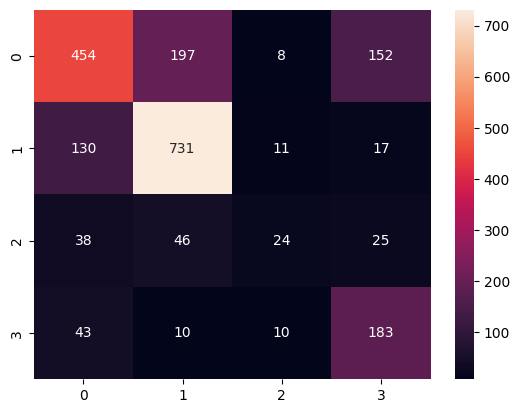

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
neutral


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,970,286 (15.15 MB)

 Trainable params: 1,323,428 (5.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,646,858 (10.10 MB)

In [18]:
# ===============================
# PROJECT 1 : SENTIMENT ANALYSIS USING KERAS (DEEP LEARNING)
# ===============================

# 1. IMPORT LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# 2. LOAD DATASET
df = pd.read_csv('/content/Mental Health Dataset.csv')   # change name if needed
# Expected columns: text , label

print(df.head())
print(df.shape)

# 3. BASIC CLEANING
print(df.isnull().sum())
df.dropna(inplace=True)

# 4. TEXT CLEANING FUNCTION
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

df['clean_text'] = df['posts'].apply(clean_text)
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['predicted'])

# 6. TOKENIZATION
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(df['clean_text'])

sequences = tokenizer.texts_to_sequences(df['clean_text'])

max_len = 100
X = pad_sequences(sequences, maxlen=max_len, padding='post')
y = df['label_encoded']

# 7. TRAIN TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 8. BUILD KERAS MODEL
model = Sequential([
    Embedding(vocab_size, 128, input_length=max_len),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


# 9. TRAIN MODEL
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)

# 10. MODEL EVALUATION
y_pred = np.argmax(model.predict(X_test), axis=1)

print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

# 11. CUSTOM SENTENCE PREDICTION
def predict_sentiment_dl(text):
    text = clean_text(text)
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model.predict(padded)
    return le.inverse_transform([np.argmax(pred)])[0]

print(predict_sentiment_dl('I feel very depressed and lonely'))
model.summary()

In [19]:
# Download GloVe
!wget http://nlp.stanford.edu/data/glove.6B.zip

# Unzip
!unzip glove.6B.zip


--2026-01-28 11:08:42--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2026-01-28 11:08:42--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2026-01-28 11:08:43--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

                                               posts predicted  intensity
0  I know as parent of child with down syndrome t...  negative         -1
1  but in my heart I know this is the future prom...   neutral          0
2  I have mylefibrosis which turn to leukemia the...  negative         -1
3  from one of my health group subject wayne dyer...   neutral          0
4  gmos now link to leukemia http nsnbc I 2013 07...   neutral          0
(10392, 3)
Total GloVe words loaded: 400000
Class Weights: {0: np.float64(0.6318029796290666), 1: np.float64(0.5938839668476708), 2: np.float64(3.4633333333333334), 3: np.float64(2.2489177489177488)}
Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5384 - loss: 1.0788 - val_accuracy: 0.6397 - val_loss: 0.8452
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6435 - loss: 0.8561 - val_accuracy: 0.6556 - val_loss: 0.8442
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6651 - loss: 0.8116 - val_accur

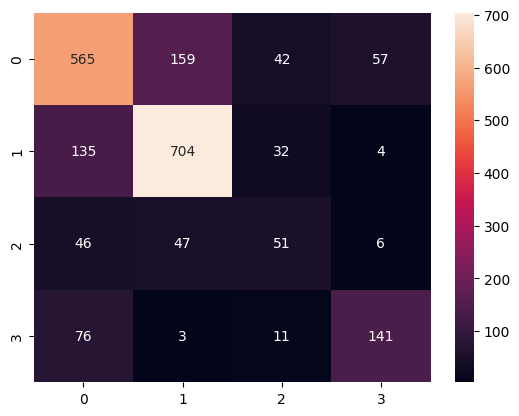

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
very negative


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,266,222 (4.83 MB)

 Trainable params: 88,740 (346.64 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

 Optimizer params: 177,482 (693.29 KB)

In [20]:
# ===============================
# P2 PROJECT : SENTIMENT ANALYSIS USING KERAS + GloVe EMBEDDINGS
# ===============================

# 1. IMPORT LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# 2. LOAD DATASET
df = pd.read_csv('/content/Mental Health Dataset.csv')  # change if needed
# Columns: posts, predicted, intensity

print(df.head())
print(df.shape)

# 3. BASIC CLEANING
df.dropna(inplace=True)

# 4. TEXT CLEANING FUNCTION
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

df['clean_text'] = df['posts'].apply(clean_text)

# 5. LABEL ENCODING
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['predicted'])

# 6. TOKENIZATION
vocab_size = 10000
max_len = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(df['clean_text'])

sequences = tokenizer.texts_to_sequences(df['clean_text'])
X = pad_sequences(sequences, maxlen=max_len, padding='post')
y = df['label_encoded']

# 7. TRAIN TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ===============================
# 8. LOAD PRETRAINED GloVe EMBEDDINGS
# ===============================

# Download glove.6B.100d.txt manually and place in same directory
# https://nlp.stanford.edu/projects/glove/

glove_path = 'glove.6B.100d.txt'
embedding_dim = 100

embeddings_index = {}
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

print('Total GloVe words loaded:', len(embeddings_index))

# CREATE EMBEDDING MATRIX
word_index = tokenizer.word_index
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# ===============================
# 9. BUILD KERAS MODEL WITH GloVe
# ===============================

model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False  # IMPORTANT: freeze embeddings
    ),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
# 10. HANDLE CLASS IMBALANCE (class_weight)
# ===============================


from sklearn.utils.class_weight import compute_class_weight


# Compute class weights
class_weights = compute_class_weight(
class_weight='balanced',
classes=np.unique(y_train),
y=y_train
)


class_weight_dict = dict(enumerate(class_weights))
print('Class Weights:', class_weight_dict)

# 10. TRAIN MODEL
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)

# 11. MODEL EVALUATION
y_pred = np.argmax(model.predict(X_test), axis=1)

print('Test Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

# 12. CUSTOM SENTENCE PREDICTION
def predict_sentiment_glove(text):
    text = clean_text(text)
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model.predict(padded)
    return le.inverse_transform([np.argmax(pred)])[0]

print(predict_sentiment_glove('I feel very depressed and lonely'))
model.summary()
# ===============================
# END OF KERAS + GloVe P2 PROJECT
# ===============================

In [21]:
# 12. CUSTOM SENTENCE PREDICTION
def predict_sentiment_glove(text):
    text = clean_text(text)
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model.predict(padded)
    return le.inverse_transform([np.argmax(pred)])[0]

print(predict_sentiment_glove('I am not sure youall rember how confusing the name change were for ampyra when it first come out campath is another one that will be confuse just let folk know what they are look for campath is that med in phase iii trial predict to be on the market in the first quater of next year because it have been give fda fast track status in trial it have reduce miss lesion more than any other drug at 86 its the one that is 5 consecutive day of iv infusion the first year than 3 consective day every year after that but miss treatment only 1x a year kind of set it every year and forget it kind of med that is campath it is currently use to treat leukemia when it is release to treat miss it will be call lemtrada campath for leukemia lemtrada for miss the back ground on this name change is a little less ethical but expect campath is about a third of the cost of any miss me on the market so if they begin to sell it for miss treatment they have to raise the price hence the name change campath will be a third of the cost of lemtrada they need separate name to do that http www bloomberg com news 2011 02 16 genzyme s experimental miss drug to profit investor only if it have success html'))
model.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
neutral


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,266,222 (4.83 MB)

 Trainable params: 88,740 (346.64 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

 Optimizer params: 177,482 (693.29 KB)

In [ ]:
requirements = """streamlit
numpy
pandas
scikit-learn
nltk
joblib
"""

with open("requirements.txt", "w") as f:
    f.write(requirements)

print("requirements.txt created")


In [23]:
%%writefile requirements.txt
streamlit
numpy
pandas
scikit-learn
nltk
joblib

Writing requirements.txt


In [26]:
%%writefile app.py
import streamlit as st
import joblib
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

st.set_page_config(page_title="Mental Health Intensity Predictor")

st.title("🧠 Mental Health Intensity Prediction")

@st.cache_resource
def load_nltk():
    nltk.download("punkt")
    nltk.download("stopwords")
    nltk.download("wordnet")

load_nltk()

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z]", " ", text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

@st.cache_resource
def load_models():
    tfidf = joblib.load("tfidf_vectorizer.pkl")
    model = joblib.load("logreg_model.pkl")
    return tfidf, model

tfidf, model = load_models()

text = st.text_area("Enter text")

if st.button("Predict"):
    clean = clean_text(text)
    vec = tfidf.transform([clean])
    pred = model.predict(vec)[0]
    conf = max(model.predict_proba(vec)[0])

    st.write("Prediction:", pred)
    st.write("Confidence:", round(conf, 2))


Writing app.py
